In [1]:
import sys
import tensorflow as tf
import numpy as np
from google.colab import drive
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report

In [2]:
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
%cd ./drive/MyDrive/CommonSwissBirds

/content/drive/MyDrive/CommonSwissBirds


In [4]:
%ls

01_data_prep/  03_base_model/  05_efficientNetV2L/   utils/
02_data/       04_resnet_50/   06_mobileNetV3_mini/


In [5]:
sys.path.append('./utils')
import utils

In [6]:
print(f"The number of GPUs: {len(tf.config.list_physical_devices('GPU'))}")
!nvidia-smi -L

The number of GPUs: 1
GPU 0: Tesla T4 (UUID: GPU-139fecab-7642-e560-0108-2f28e0fc428c)


In [7]:
class_names=['amsel', 'blaumeise', 'buchfink', 'elster', 'hausrotschwanz', 'hausspatz', 'kohlmeise', 'rabenkraehe', 'star', 'tuerkentaube']

In [8]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './02_data/99_dataset_preparation/train_images',
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="training",
)

Found 5000 files belonging to 10 classes.
Using 4000 files for training.


In [9]:
valid_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './02_data/99_dataset_preparation/train_images',
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=True,
    seed=42,
    validation_split=0.2,
    subset="validation",
)

Found 5000 files belonging to 10 classes.
Using 1000 files for validation.


In [10]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './02_data/99_dataset_preparation/test_images',
    labels='inferred',
    label_mode='categorical',
    class_names=class_names,
    color_mode='rgb',
    batch_size=32,
    image_size=(224, 224),
    shuffle=False,
)

Found 1222 files belonging to 10 classes.


In [11]:
showcase_ds = tf.keras.preprocessing.image_dataset_from_directory(
    './02_data/99_dataset_preparation/showcase_images',
    labels='inferred',
    label_mode='int',
    class_names=['amsel', 'blaumeise', 'buchfink', 'elster', 'hausrotschwanz', 'hausspatz', 'kohlmeise', 'rabenkraehe', 'star', 'tuerkentaube'],
    color_mode='rgb',
    shuffle=False,
    batch_size=30,
    image_size=(224, 224),
)


Found 30 files belonging to 10 classes.


In [12]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)
showcase_ds = showcase_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [13]:
base_model = ResNet50(weights='imagenet', include_top=False)
model = utils.recompile_custom_output(base_model)

94765736/94765736 [==============================] - 5s 0us/step


In [14]:
callbacks = [EarlyStopping(monitor='val_accuracy', mode = "max", patience=2),
ModelCheckpoint(
    filepath=r'./04_resnet_50/model/best.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)]

In [15]:
# train the model on the new data for a few epochs
history = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=50,
  callbacks=[callbacks],
)

Epoch 1/50
125/125 [==============================] - 1848s 14s/step - loss: 1.4689 - accuracy: 0.6385 - val_loss: 0.7344 - val_accuracy: 0.7420
Epoch 2/50
125/125 [==============================] - 19s 156ms/step - loss: 0.4407 - accuracy: 0.8500 - val_loss: 0.6404 - val_accuracy: 0.8000
Epoch 3/50
125/125 [==============================] - 18s 140ms/step - loss: 0.2593 - accuracy: 0.9112 - val_loss: 0.7581 - val_accuracy: 0.8130
Epoch 4/50
125/125 [==============================] - 17s 138ms/step - loss: 0.1829 - accuracy: 0.9390 - val_loss: 0.5955 - val_accuracy: 0.8490
Epoch 5/50
125/125 [==============================] - 17s 137ms/step - loss: 0.1458 - accuracy: 0.9523 - val_loss: 0.3780 - val_accuracy: 0.9030
Epoch 6/50
125/125 [==============================] - 18s 141ms/step - loss: 0.1116 - accuracy: 0.9653 - val_loss: 0.3713 - val_accuracy: 0.9100
Epoch 7/50
125/125 [==============================] - 16s 126ms/step - loss: 0.0853 - accuracy: 0.9693 - val_loss: 1.0037 - val_ac

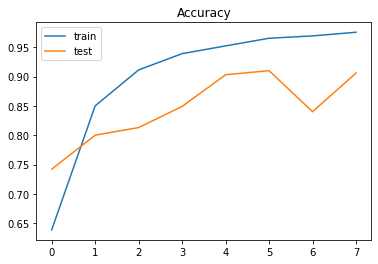

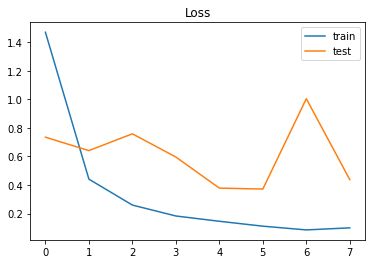

In [16]:
%matplotlib inline
utils.plot_history(history)

In [17]:
callbacks = [EarlyStopping(monitor='val_accuracy', mode = "max", patience=2),
ModelCheckpoint(
    filepath=r'./04_resnet_50/model/best_finetuned.h5',
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)]

In [18]:
for layer in base_model.layers:
    layer.trainable = True

# recompile the model for these modifications to take effect
# we use SGD with a low learning rate
from tensorflow.keras.optimizers import SGD
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again 
histroy = model.fit(
  train_ds,
  validation_data=valid_ds,
  epochs=50,
  callbacks=[callbacks]
)

Epoch 1/50


/usr/local/lib/python3.8/dist-packages/keras/optimizers/optimizer_v2/gradient_descent.py:108: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


125/125 [==============================] - 56s 392ms/step - loss: 0.5216 - accuracy: 0.8972 - val_loss: 0.4237 - val_accuracy: 0.9220
Epoch 2/50
125/125 [==============================] - 47s 375ms/step - loss: 0.0364 - accuracy: 0.9900 - val_loss: 0.2150 - val_accuracy: 0.9570
Epoch 3/50
125/125 [==============================] - 44s 353ms/step - loss: 0.0070 - accuracy: 0.9992 - val_loss: 0.2364 - val_accuracy: 0.9480
Epoch 4/50
125/125 [==============================] - 45s 362ms/step - loss: 0.0038 - accuracy: 0.9998 - val_loss: 0.2402 - val_accuracy: 0.9500


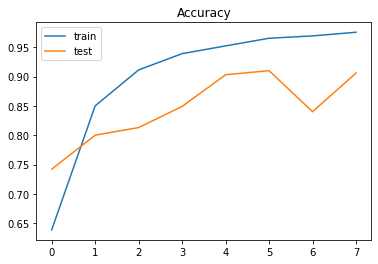

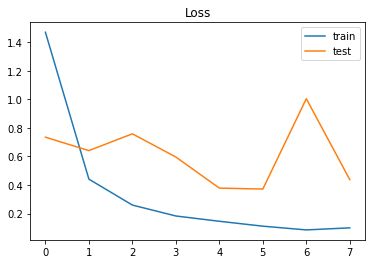

In [19]:
%matplotlib inline
utils.plot_history(history)

In [20]:
# Possible to start here without training... just loading the new weights...
base_model = ResNet50(weights='imagenet', include_top=False)
model = utils.recompile_custom_output(base_model)
model.load_weights('./04_resnet_50/model/best_finetuned.h5')

In [21]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test_ds, batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
39/39 [==============================] - 493s 13s/step - loss: 0.4421 - accuracy: 0.9133
test loss, test acc: [0.44209471344947815, 0.9132569432258606]


In [22]:
testset_predictions = model.predict(test_ds)
predicted_labels = [prediction.argmax() for prediction in testset_predictions]
true_labels = utils.get_labels_from_categorical_batch_dataset(test_ds)
confusion_matrix = np.array(tf.math.confusion_matrix(true_labels, predicted_labels))

39/39 [==============================] - 5s 99ms/step


In [23]:
print(classification_report(true_labels, predicted_labels, target_names=class_names))

                precision    recall  f1-score   support

         amsel       0.92      0.90      0.91       113
     blaumeise       0.90      0.90      0.90       125
      buchfink       0.87      0.91      0.89       125
        elster       0.94      0.90      0.92       113
hausrotschwanz       0.90      0.95      0.92       117
     hausspatz       0.88      0.85      0.86       133
     kohlmeise       0.89      0.92      0.91       125
   rabenkraehe       0.96      0.92      0.94       121
          star       0.96      0.93      0.94       125
  tuerkentaube       0.93      0.96      0.94       125

      accuracy                           0.91      1222
     macro avg       0.91      0.91      0.91      1222
  weighted avg       0.91      0.91      0.91      1222



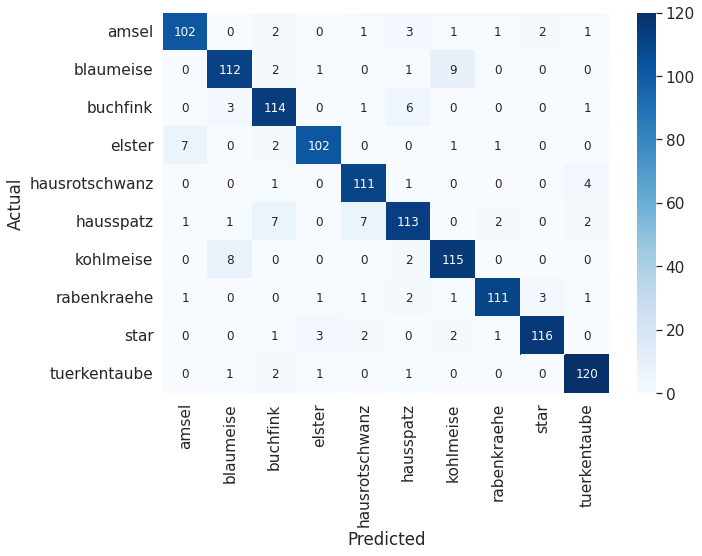

In [24]:
%matplotlib inline
utils.plot_sns_confusion_matrix(confusion_matrix, class_names)

In [25]:
showcase_predictions = model.predict(showcase_ds)
predicted_labels = [prediction.argmax() for prediction in showcase_predictions]
true_labels = [label.numpy() for label in [labels for images, labels in showcase_ds.take(1)][0]]
confusion_matrix = np.array(tf.math.confusion_matrix(true_labels, predicted_labels))

1/1 [==============================] - 14s 14s/step


In [26]:
print(classification_report(true_labels, predicted_labels, target_names=class_names))

                precision    recall  f1-score   support

         amsel       1.00      1.00      1.00         3
     blaumeise       0.67      0.67      0.67         3
      buchfink       1.00      0.67      0.80         3
        elster       1.00      1.00      1.00         3
hausrotschwanz       1.00      1.00      1.00         3
     hausspatz       1.00      1.00      1.00         3
     kohlmeise       0.75      1.00      0.86         3
   rabenkraehe       1.00      1.00      1.00         3
          star       1.00      1.00      1.00         3
  tuerkentaube       1.00      1.00      1.00         3

      accuracy                           0.93        30
     macro avg       0.94      0.93      0.93        30
  weighted avg       0.94      0.93      0.93        30



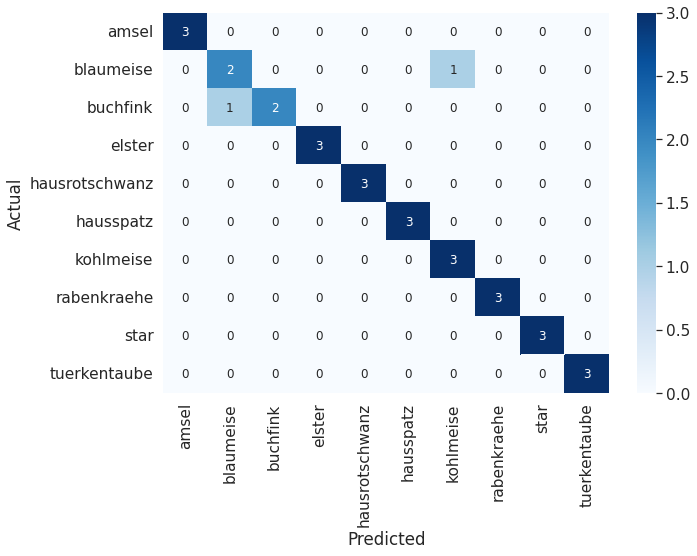

In [27]:
%matplotlib inline
utils.plot_sns_confusion_matrix(confusion_matrix, class_names)

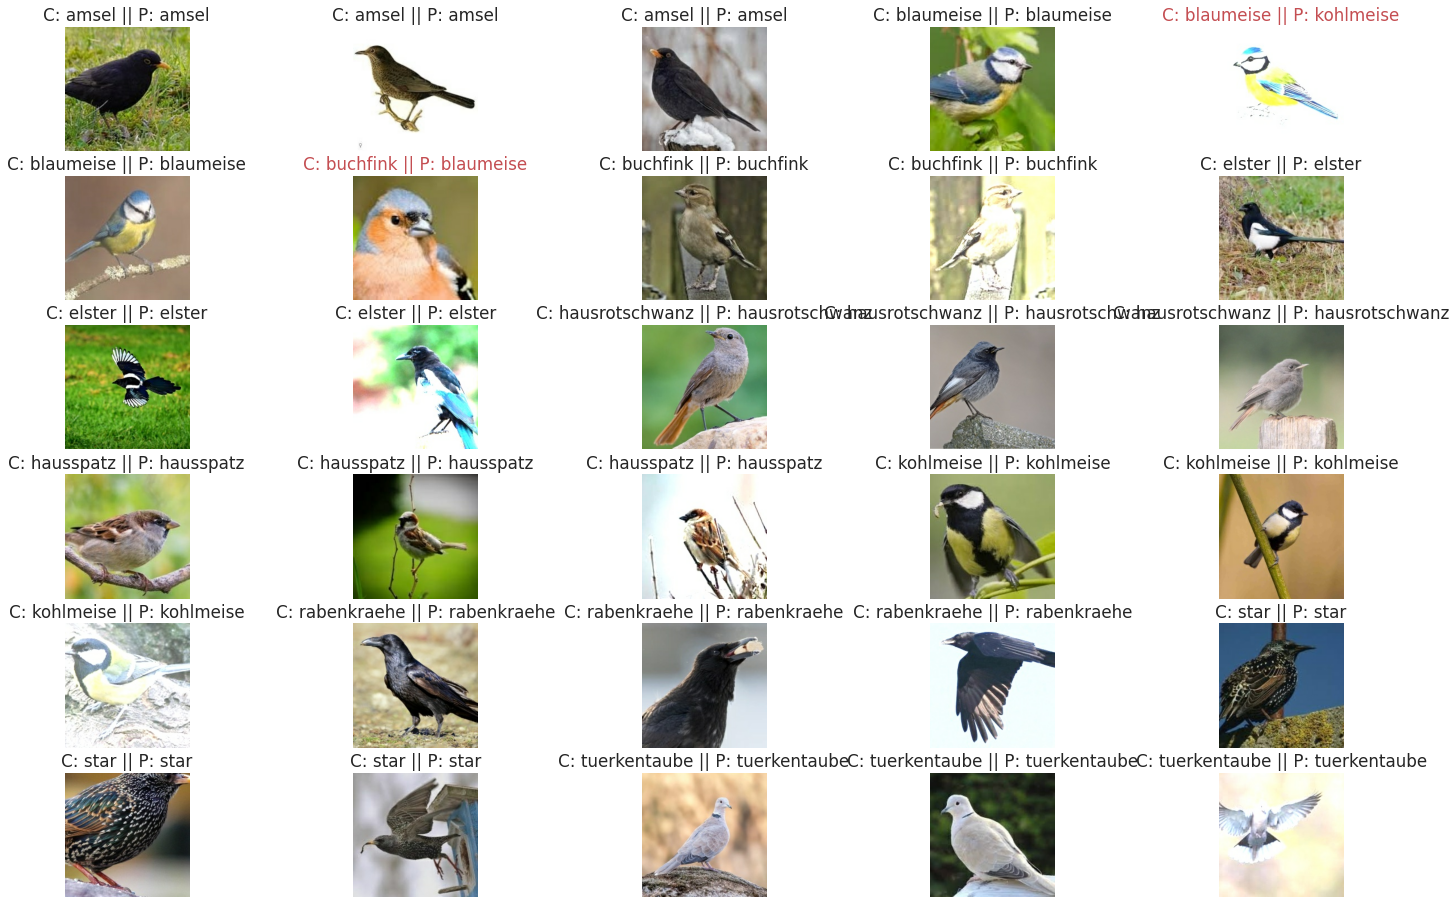

In [28]:
%matplotlib inline
utils.plot_showcase(showcase_ds, class_names, showcase_predictions)

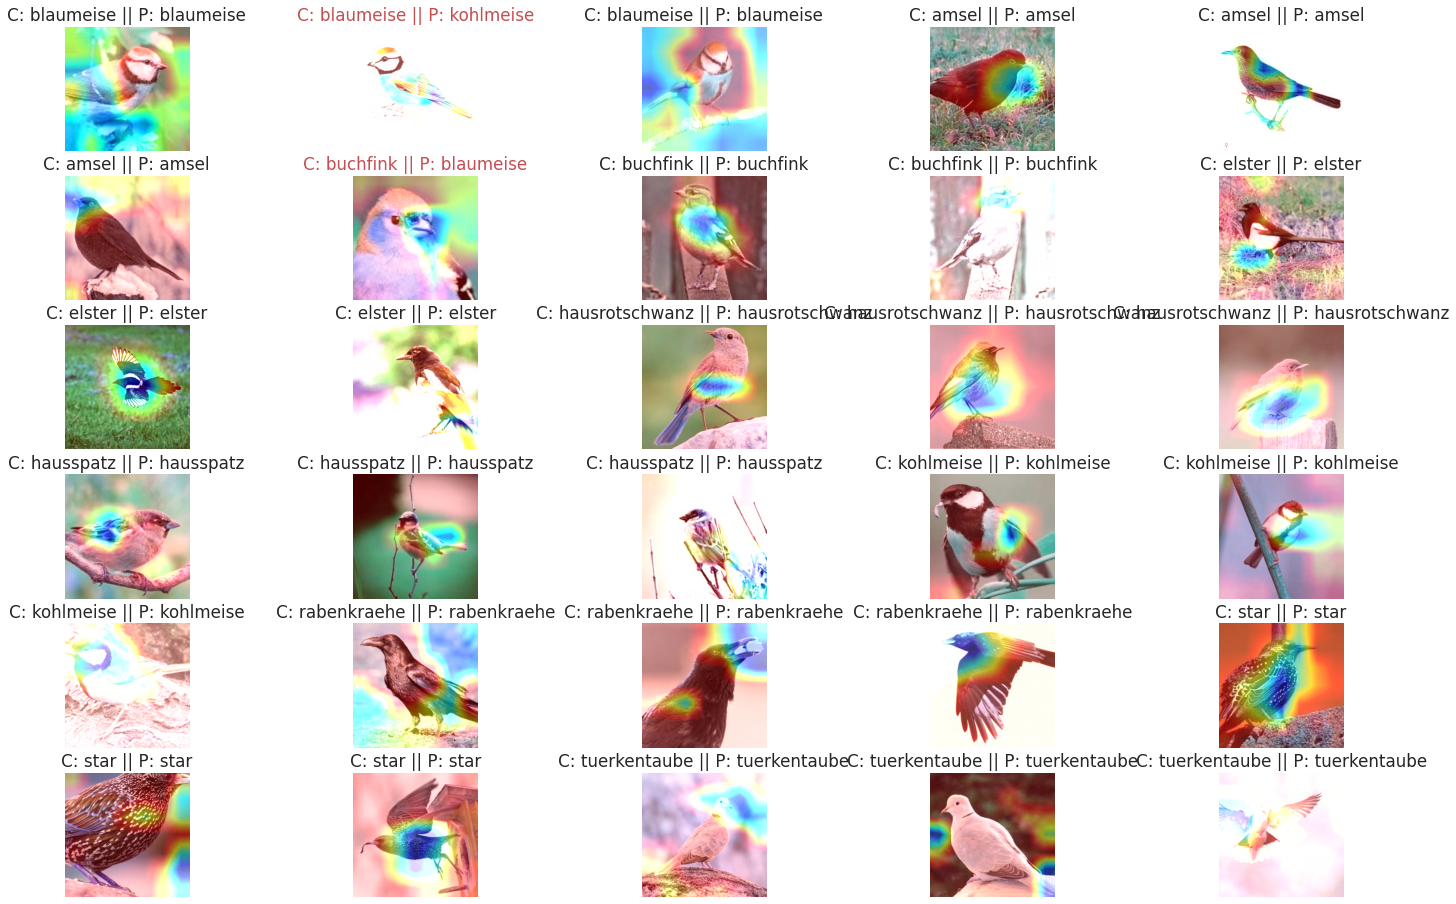

In [29]:
showcase_path = './02_data/99_dataset_preparation/showcase_images'
last_convolution_layer_name = 'conv5_block3_3_conv'
utils.plot_showcase_gradcam_overlay(showcase_path, class_names, model, last_convolution_layer_name)

In [30]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, None,  0           []                               
                                 3)]                                                              
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, None, None,   0           ['input_2[0][0]']                
                                3)                                                                
                                                                                                  
 conv1_conv (Conv2D)            (None, None, None,   9472        ['conv1_pad[0][0]']              
                                64)                                                         